## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import scipy.stats
import pylab
import os
import requests
import logging
#sns.set()

Download the data

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)



def download_data(save_path='data/data.csv'):
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=IPG2211A2N&scale=left&cosd=1939-01-01&coed=2024-10-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-21&revision_date=2024-11-21&nd=1939-01-01"
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    os.makedirs(os.path.dirname(save_path), exist_ok=True) # Check if the download was successful
    with open(save_path, 'wb') as file:
        file.write(response.content)
    
    logger.info(f"Data downloaded and saved to {save_path}")


In [3]:
download_data()

2024-11-30 02:47:37,425 - INFO - Data downloaded and saved to data/data.csv


Displaying a summary of the DataFrame

In [4]:
df = pd.read_csv('./data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1030 non-null   object 
 1   IPG2211A2N  1030 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


Insights from `df.info()` Output

- Data Type: The dataset is a Pandas DataFrame.
- Shape: The DataFrame contains 1030 rows  and 2 columns.
- Columns:
  - `DATE`: Contains 1030 non-null values with the data type `object`, likely representing dates.
  - `IPG2211A2N`: Contains 1030 non-null values with the data type `float64`, representing numerical values.


preprocess the data

In [5]:
file_path='data/data.csv'

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df = df.rename(columns={'IPG2211A2N': 'Production_Index', 'DATE': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
    df = df.set_index('Date')
    df = df.asfreq('MS', fill_value=np.nan)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]
    logger.info('Data preprocessing done')
    return df



In [6]:
df = preprocess_data(file_path)
df

2024-11-30 02:47:38,173 - INFO - Data preprocessing done


,Production_Index
Date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608
...,...
2024-06-01,109.1424
2024-07-01,120.0882
2024-08-01,118.4131


## Zooming Into Key Historical Events

In this section, I will analyze the impact of major global and U.S. events on the utilities production index.

By zooming into specific time periods associated with significant historical events, we can visually observe how production trends correlate with each event.

The following events are covered:

- **World War II (1939-1945)**
- **Post-War Economic Boom (1945-1960)**
- **Energy Crisis (1973-1974)**
- **Dot-Com Bubble (1997-2000)**
- **Great Recession (2007-2009)**
- **Obama’s Clean Energy Initiatives (2009-2017)**
- **US-China Trade War (2018-2020)**
- **COVID-19 Pandemic (2020-2021)**
- **Russia-Ukraine Conflict (2022-2024)**

These visualizations will help identify how different events might have influenced the production index over time.


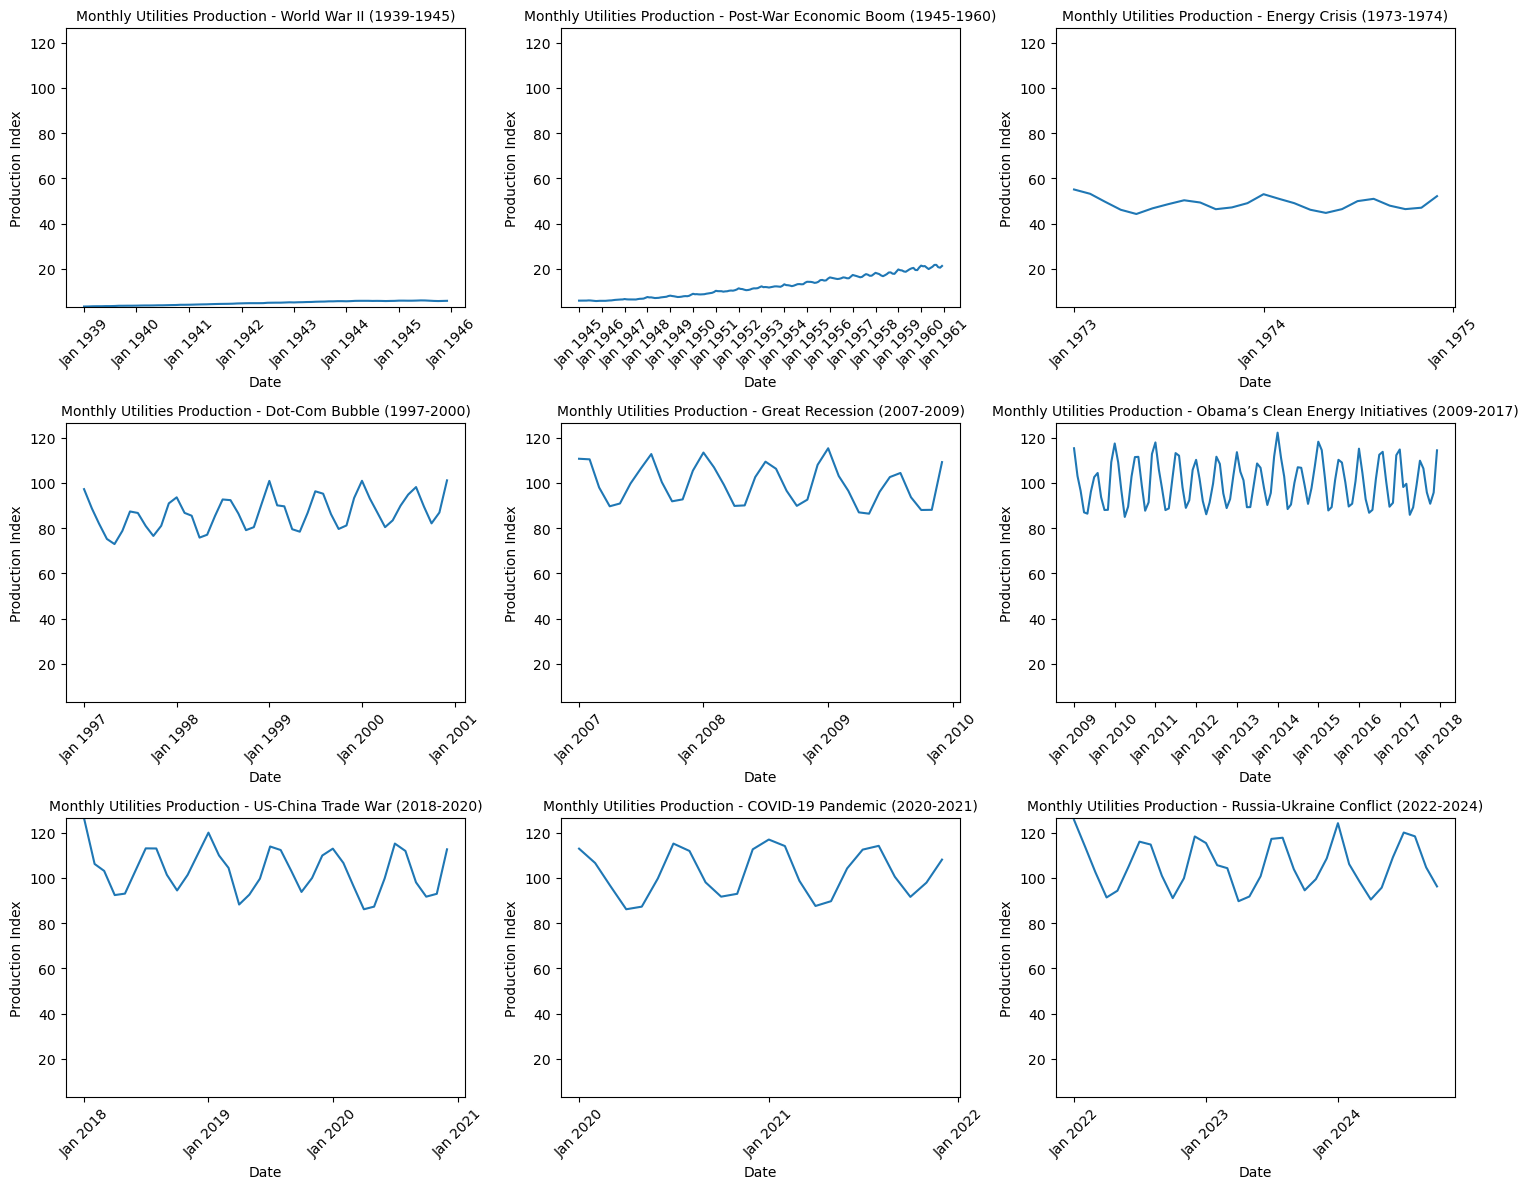

In [7]:
# Global y-axis limits based on the full dataset
y_min = df['Production_Index'].min()  # minimum value
y_max = df['Production_Index'].max()  # maximum value

# Define the periods to plot
periods = [
    ('1939-01-01', '1945-12-31', 'World War II (1939-1945)'),
    ('1945-01-01', '1960-12-31', 'Post-War Economic Boom (1945-1960)'),
    ('1973-01-01', '1974-12-31', 'Energy Crisis (1973-1974)'),
    ('1997-01-01', '2000-12-31', 'Dot-Com Bubble (1997-2000)'),
    ('2007-01-01', '2009-12-31', 'Great Recession (2007-2009)'),
    ('2009-01-01', '2017-12-31', 'Obama’s Clean Energy Initiatives (2009-2017)'),
    ('2018-01-01', '2020-12-31', 'US-China Trade War (2018-2020)'),
    ('2020-01-01', '2021-12-31', 'COVID-19 Pandemic (2020-2021)'),
    ('2022-01-01', '2024-12-31', 'Russia-Ukraine Conflict (2022-2024)')
]

# Create a figure with multiple subplots (3 plots per row)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

for i, (start_date, end_date, title) in enumerate(periods):
    ax = axes[i]
    ax.plot(df.loc[start_date:end_date]['Production_Index'])
    ax.set_xlabel("Date")
    ax.set_ylabel("Production Index")
    ax.set_title(f'Monthly Utilities Production - {title}', size= 10)
    ax.set_ylim(y_min, y_max)  # set the same y-axis range
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params('x', labelrotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Plotting the Complete Dataset with Historical Events

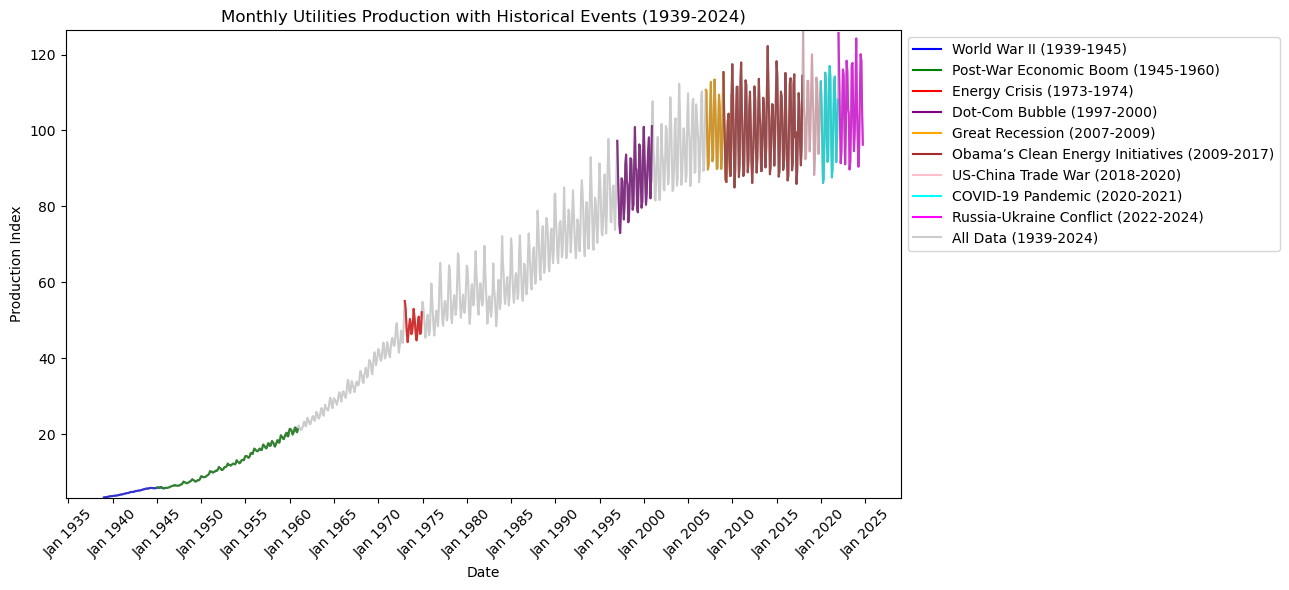

In [8]:
# Plotting all events with the rest of the data in gray

# Global y-axis limits based on the full dataset
y_min = df['Production_Index'].min()
y_max = df['Production_Index'].max()

fig, ax = plt.subplots(figsize=(13,6))

# World War II (1939-1945)
ax.plot(df.loc['1939-01-01':'1945-12-31']['Production_Index'], label="World War II (1939-1945)", color='blue')

# Post-War Economic Boom (1945-1960)
ax.plot(df.loc['1945-01-01':'1960-12-31']['Production_Index'], label="Post-War Economic Boom (1945-1960)", color='green')

# Energy Crisis (1973-1974)
ax.plot(df.loc['1973-01-01':'1974-12-31']['Production_Index'], label="Energy Crisis (1973-1974)", color='red')

# Dot-Com Bubble (1997-2000)
ax.plot(df.loc['1997-01-01':'2000-12-31']['Production_Index'], label="Dot-Com Bubble (1997-2000)", color='purple')

# Great Recession (2007-2009)
ax.plot(df.loc['2007-01-01':'2009-12-31']['Production_Index'], label="Great Recession (2007-2009)", color='orange')

# Obama’s Clean Energy Initiatives (2009-2017)
ax.plot(df.loc['2009-01-01':'2017-12-31']['Production_Index'], label="Obama’s Clean Energy Initiatives (2009-2017)", color='brown')

# US-China Trade War (2018-2020)
ax.plot(df.loc['2018-01-01':'2020-12-31']['Production_Index'], label="US-China Trade War (2018-2020)", color='pink')

# COVID-19 Pandemic (2020-2021)
ax.plot(df.loc['2020-01-01':'2021-12-31']['Production_Index'], label="COVID-19 Pandemic (2020-2021)", color='cyan')

# Russia-Ukraine Conflict (2022-2024)
ax.plot(df.loc['2022-01-01':'2024-12-31']['Production_Index'], label="Russia-Ukraine Conflict (2022-2024)", color='magenta')

# Plot the rest of the data in gray
ax.plot(df['Production_Index'], color='gray', label="All Data (1939-2024)", alpha=0.4)

# Adding labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title("Monthly Utilities Production with Historical Events (1939-2024)")

# Set y-axis limits to ensure consistency
ax.set_ylim(y_min, y_max)

# Adding a legend to differentiate the events
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Formatting the x-axis for better readability
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params('x', labelrotation=45)

# Display the plot
plt.tight_layout()
plt.show()


Plotting Event Periods Against Relative Indices for Comparison

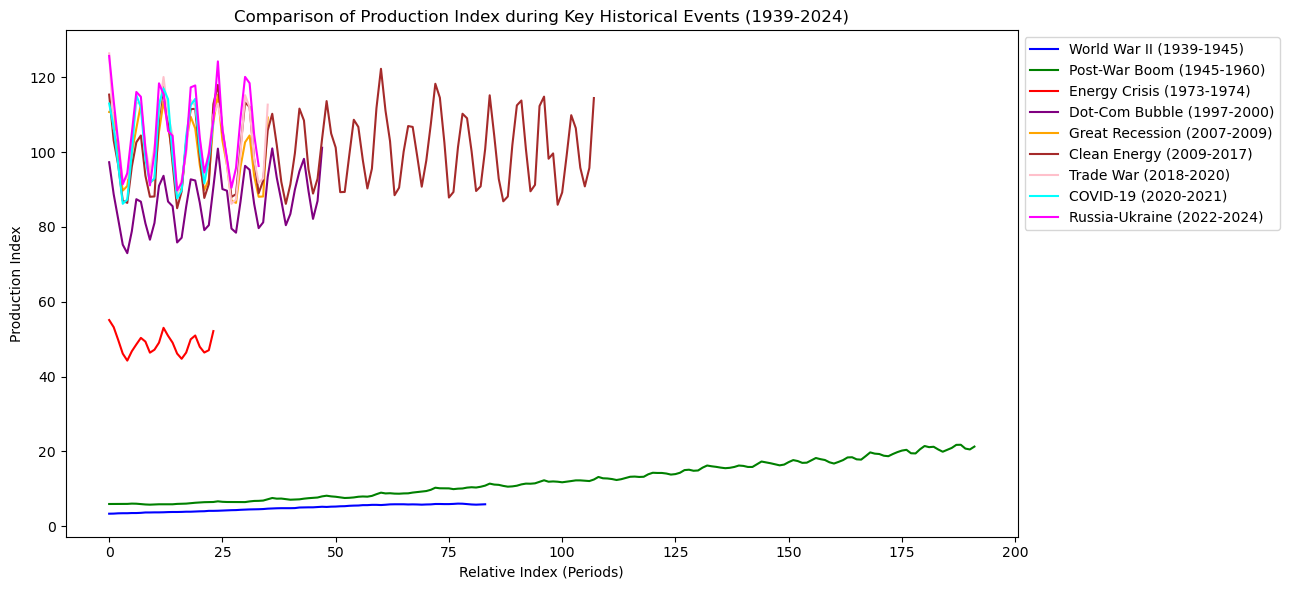

In [9]:
# Extract production index values for each event period
event_periods = {
    "World War II (1939-1945)": ('1939-01-01', '1945-12-31', 'blue'),
    "Post-War Boom (1945-1960)": ('1945-01-01', '1960-12-31', 'green'),
    "Energy Crisis (1973-1974)": ('1973-01-01', '1974-12-31', 'red'),
    "Dot-Com Bubble (1997-2000)": ('1997-01-01', '2000-12-31', 'purple'),
    "Great Recession (2007-2009)": ('2007-01-01', '2009-12-31', 'orange'),
    "Clean Energy (2009-2017)": ('2009-01-01', '2017-12-31', 'brown'),
    "Trade War (2018-2020)": ('2018-01-01', '2020-12-31', 'pink'),
    "COVID-19 (2020-2021)": ('2020-01-01', '2021-12-31', 'cyan'),
    "Russia-Ukraine (2022-2024)": ('2022-01-01', '2024-12-31', 'magenta'),
}

# Plot event periods for comparison
fig, ax = plt.subplots(figsize=(13, 6))

for event, (start, end, color) in event_periods.items():
    values = df.loc[start:end]['Production_Index']
    ax.plot(values.values, label=event, color=color)

# Add labels, title, and legend
ax.set_xlabel("Relative Index (Periods)")
ax.set_ylabel("Production Index")
ax.set_title("Comparison of Production Index during Key Historical Events (1939-2024)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


Plotting Yearly and Monthly Trends Using Line Plots

In [10]:
# extracting additional columns for data analysis
df['Month'] = df.index.month
df['Year'] = df.index.year
df.head()

,Production_Index,Month,Year
Date,,,
1939-01-01,3.3336,1,1939
1939-02-01,3.3591,2,1939
1939-03-01,3.4354,3,1939
1939-04-01,3.4608,4,1939
1939-05-01,3.4608,5,1939


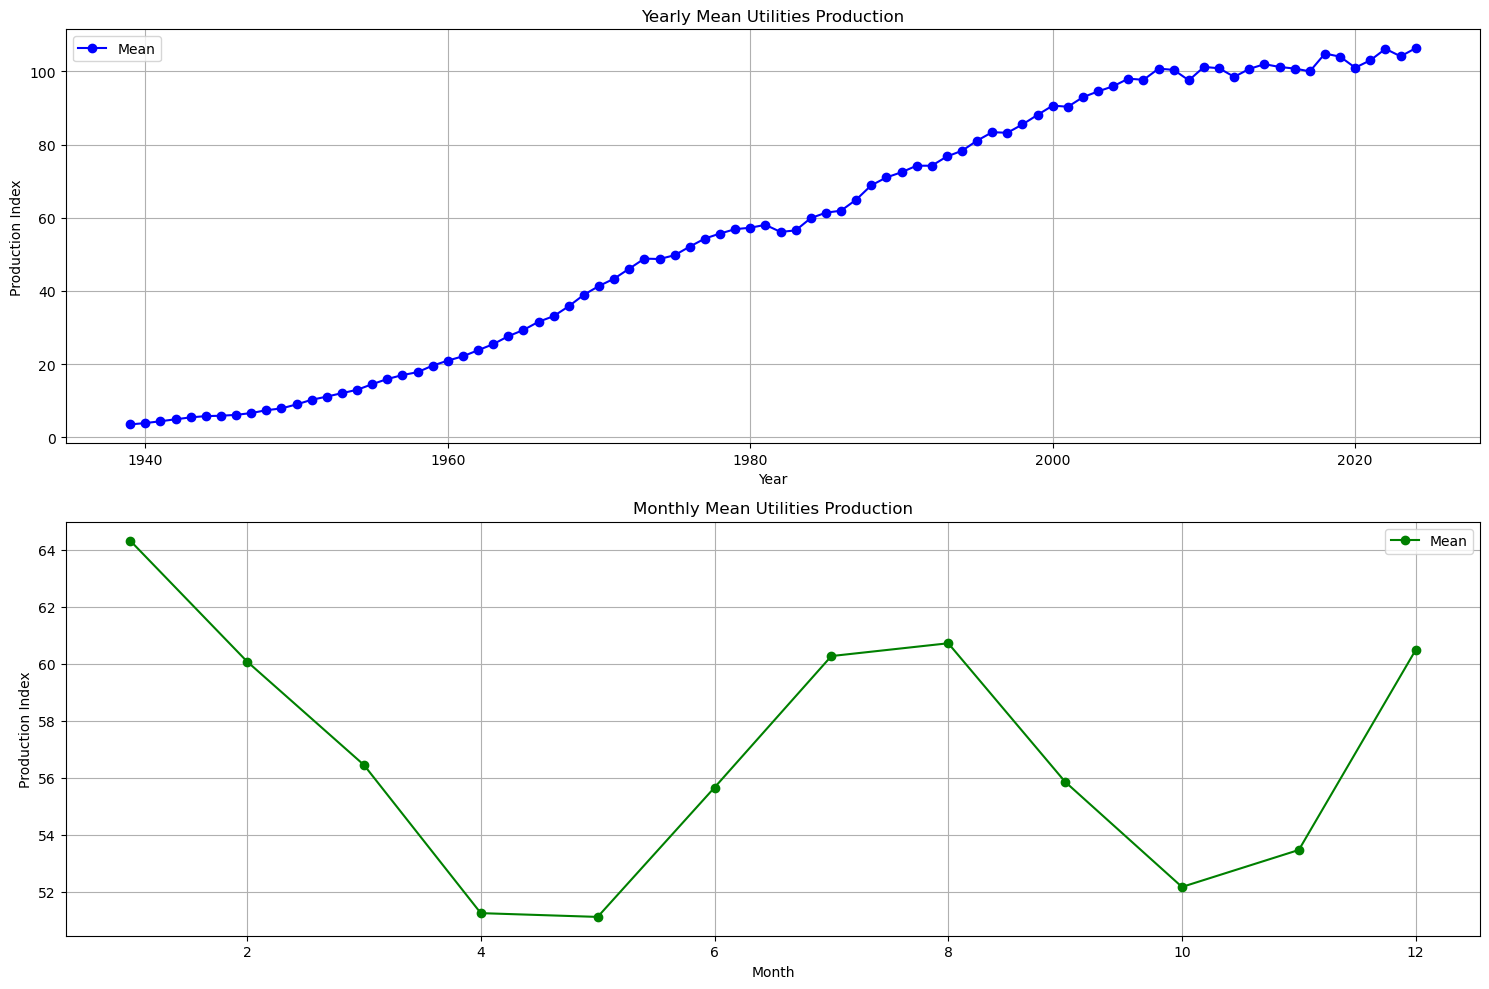

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Yearly Line Plot
df.groupby('Year')['Production_Index'].mean().plot(ax=axes[0], marker='o', linestyle='-', color='blue', label='Mean')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Production Index")
axes[0].set_title('Yearly Mean Utilities Production')
axes[0].grid(True)
axes[0].legend()

# Monthly Line Plot
df.groupby('Month')['Production_Index'].mean().plot(ax=axes[1], marker='o', linestyle='-', color='green', label='Mean')
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Production Index")
axes[1].set_title('Monthly Mean Utilities Production')
axes[1].grid(True)
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Yearly Mean Utilities Production
The plot illustrates the yearly mean utilities production from 1939 to 2024, highlighting a clear upward trend over the 85-year period. Production values gradually increased from around 20 in the late 1930s to over 100 by the mid-2020s.

### Monthly Mean Utilities Production
The monthly mean utilities production reveals an interesting pattern where production levels increase during the summer months, contrary to typical expectations. The lowest production occurs around the spring months (around 54-55), gradually rising, peaking in late fall/early winter at 63-64, before declining again in spring. This trend shows higher utilities production in the latter half of the year, with summer months exhibiting relatively higher production compared to other months.


# Stationarity, Seasonality and Autocorrelation Analysis

ADF test

ADF Statistic: -0.7144157341270491
P-value: 0.8429801190131612 indicates that there is roughly 84.0 % chance of not rejecting the null
Number of Lags Chosen: 22
Number of Observations Used: 1007
Critical Values:
	1%: -3.436860474327014
	5%: -2.8644144230916537
	10%: -2.568300476140699
Maximum Information Criterion (AIC/BIC) Value: 4350.202909642664 'Lower values indicate a better model fit for future predictions.' 
The series is likely non-stationary (fail to reject the null hypothesis).


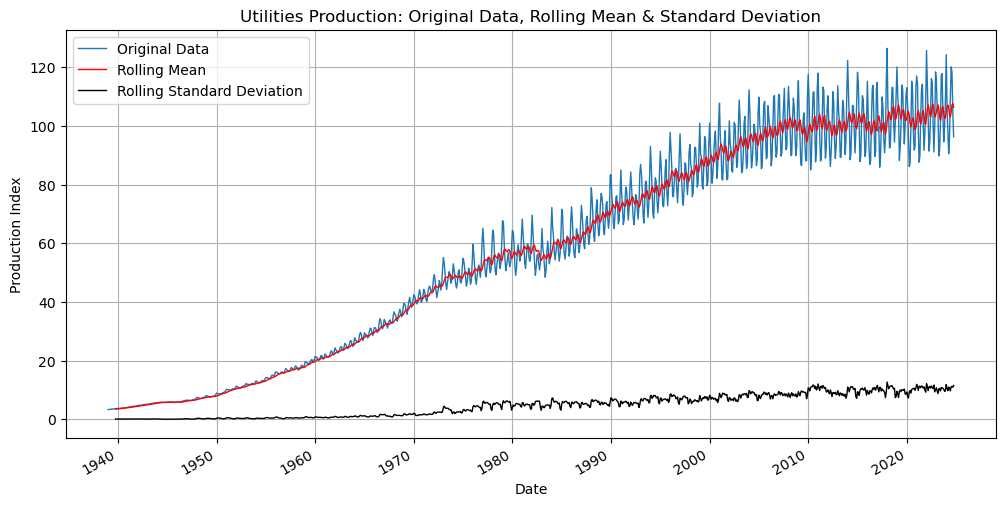

In [12]:
from statsmodels.tsa.stattools import adfuller

# Visual inspection: Plot original data, rolling mean, and rolling std
v_lags = 10  # 10 months rolling window for visualization
rolling_mean = df['Production_Index'].rolling(v_lags).mean()
rolling_std = df['Production_Index'].rolling(v_lags).std()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['Production_Index'], label="Original Data", linewidth=1.0)
ax.plot(rolling_mean, color="red", label="Rolling Mean", linewidth=1.0)
ax.plot(rolling_std, color="black", label="Rolling Standard Deviation", linewidth=1.0)
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('Utilities Production: Original Data, Rolling Mean & Standard Deviation')
ax.legend(loc='best')
ax.grid(True)
plt.gcf().autofmt_xdate()

# Perform ADF test for stationarity
adf_result = adfuller(df['Production_Index'].dropna())  # Dropping NaN values if any

# ADF Test Results
adf_statistic = adf_result[0]
p_value = adf_result[1]
lags = adf_result[2]
observations = adf_result[3]
critical_values = adf_result[4]
max_info_criteria_value = adf_result[5]


print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value} indicates that there is roughly {round(p_value, 2) * 100} % chance of not rejecting the null")
print(f"Number of Lags Chosen: {lags}")
print(f"Number of Observations Used: {observations}")
print(f"Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

print(f"Maximum Information Criterion (AIC/BIC) Value: {max_info_criteria_value} 'Lower values indicate a better model fit for future predictions.' ")

# Interpretation of ADF test
if p_value < 0.05:
    print("The series is likely stationary (reject the null hypothesis).")
else:
    print("The series is likely non-stationary (fail to reject the null hypothesis).")

plt.show()


Visual Inspection:
The 10-month rolling mean shows a drastic increase over time, and the rolling standard deviation slightly rises from 1973, indicating an upward trend and non-stationarity.

Check First Differences for Stationarity

In [13]:
df['First_Difference'] = df['Production_Index'].diff()

adf_result_diff = adfuller(df['First_Difference'].dropna())
p_value_diff = adf_result_diff[1]

if p_value_diff < 0.05:
    print("First differences are stationary: Indicates Random Walk.")
else:
    print("First differences are not stationary: Not a Random Walk.")


First differences are stationary: Indicates Random Walk.


Seasonality

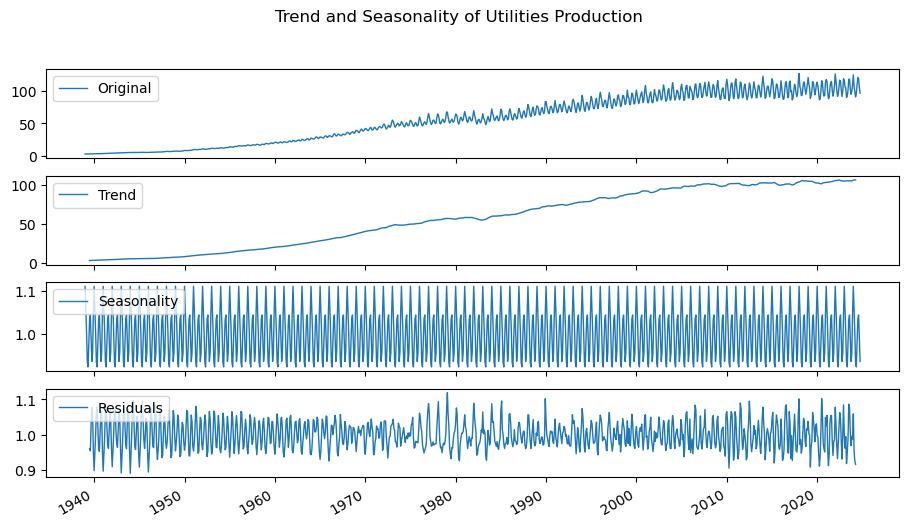

In [14]:
# plotting time series decompose plots of the entire dataset to observe trend and seasonality
df_decompose = df['Production_Index']
ts_decomposition = seasonal_decompose(df_decompose, model='multiplicative')
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid
# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, figsize=(11,6), sharex=True, sharey=False)
# First plot to the Original time series
axes[0].plot(df_decompose, label='Original', linewidth=1.0)
axes[0].legend(loc='upper left')
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend', linewidth=1.0)
axes[1].legend(loc='upper left')
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality', linewidth=1.0)
axes[2].legend(loc='upper left')
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals', linewidth=1.0)
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[3].legend(loc='upper left')
plt.gcf().autofmt_xdate()
fig.suptitle('Trend and Seasonality of Utilities Production')
plt.show()

The plot analyzes utilities production over 80 years, breaking it down into trend, seasonality, and residuals:

Raw Data: The production steadily increased from 50 units in the 1940s to over 100 units by the 2020s, showing long-term growth.

Trend: The trend line reveals consistent growth, likely driven by population and energy demand .

Seasonality: Production peaks in winter and summer, with increased seasonal fluctuations over time, possibly due to climate effects.

Residuals: deviations, likely caused by unexpected historical events mentioned previously.

Based on the graphs, the data appears to be seasonal. 
The bottom two graphs clearly show recurring seasonal patterns in the utilities production data over time.

Autocorrelation

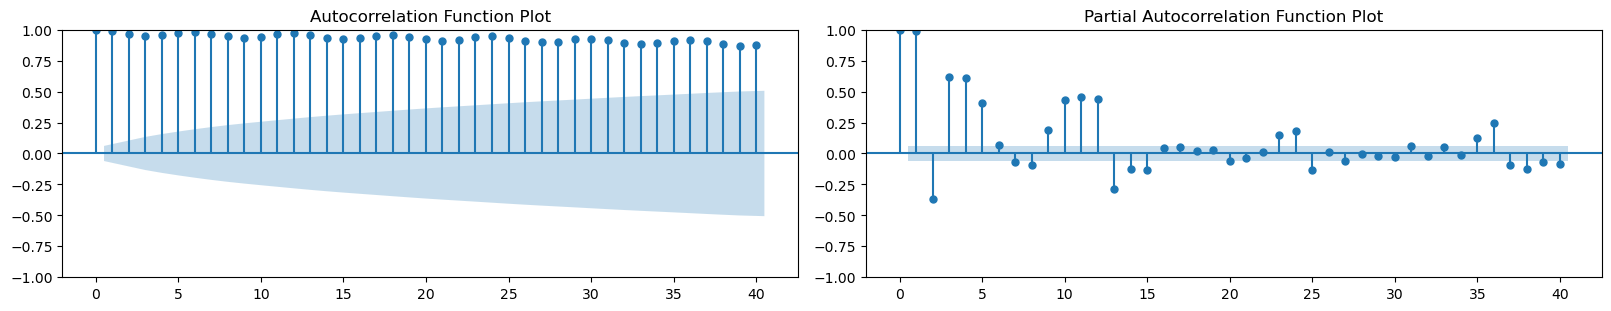

In [15]:
# plot autocorrelation and partial autocorrelation function plots to analyse autocorrelation
fig, axes = plt.subplots(1,2, figsize=(16,3), constrained_layout=True)
lags = 40
plot_acf(df['Production_Index'], ax=axes[0], lags=lags)
axes[0].set_title('Autocorrelation Function Plot')

plot_pacf(df['Production_Index'], ax=axes[1], lags=lags, method = ('ols'))
axes[1].set_title('Partial Autocorrelation Function Plot')
plt.show()

ACF: The plot shows strong positive correlations between the current and previous lags, with values above the 0.75 for the first 40 lags. The slow decay in correlation values suggests a potential trend in the series, indicating that the series IS non-stationary.Seasonal patterns are also visible, with repeating peaks and dips at regular intervals, pointing to seasonality.

PACF: PACF plot shows a sharp drop-off after lag 1, with significant spikes at a few subsequent lags. This pattern is consistent with an AR(1) process, where the series is influenced by the first lag.